In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import zscore, norm, ttest_1samp, sem, poisson


In [2]:
# Load datasets
books_df = pd.read_csv("large_books.csv")
ratings_df = pd.read_csv("large_ratings.csv")

In [2]:

# Merge datasets on book_id
merged_df = ratings_df.merge(books_df[['book_id', 'title']], on='book_id', how='left')

# Group by book title to calculate statistics
stats_df = merged_df.groupby('title')['rating'].agg(
    mean_rating='mean',
    median_rating='median',
    mode_rating=lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    variance='var',
    std_dev='std'
).reset_index()

# Display the top 10 books with the highest mean rating (sorted)
top_books = stats_df.sort_values(by='mean_rating', ascending=False).head(10)

print(top_books)

                                                  title  mean_rating  \
6683                     The Complete Calvin and Hobbes     4.829876   
2076                                    ESV Study Bible     4.818182   
720   Attack of the Deranged Mutant Killer Monster S...     4.768707   
7437                The Indispensable Calvin and Hobbes     4.766355   
8293                        The Revenge of the Baby-Sat     4.761364   
9044  There's Treasure Everywhere: A Calvin and Hobb...     4.760456   
6346  The Authoritative Calvin and Hobbes: A Calvin ...     4.757202   
3491  It's a Magical World: A Calvin and Hobbes Coll...     4.747396   
2948  Harry Potter Boxed Set, Books 1-5 (Harry Potte...     4.736842   
6568       The Calvin and Hobbes Tenth Anniversary Book     4.728528   

      median_rating  mode_rating  variance   std_dev  
6683            5.0            5  0.253742  0.503728  
2076            5.0            5  0.357367  0.597802  
720             5.0            5  0.233809

## Detecting Outliers in Book Ratings (Using the Interquartile Range (IQR) method) 

The IQR is the range between the 25th percentile (Q1) and the 75th percentile (Q3). Any rating below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR is considered an outlier.

In [3]:
# Compute IQR
Q1 = ratings_df['rating'].quantile(0.25)
Q3 = ratings_df['rating'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = ratings_df[(ratings_df['rating'] < lower_bound) | (ratings_df['rating'] > upper_bound)]

# Print number of outliers
print(f"Number of outliers: {outliers.shape[0]}")


Number of outliers: 0


## Detecting Outliers with Z-score in the User Ratings Dataset

In [7]:

# Compute Z-scores for ratings
ratings_df['z_score'] = zscore(ratings_df['rating'])

# Identify outliers (ratings with absolute Z-score > 3)
outliers = ratings_df[ratings_df['z_score'].abs() > 3]

# Display number of outliers
print(f"Number of outliers detected: {outliers.shape[0]}")

# Remove outliers from dataset
ratings_df[ratings_df['z_score'].abs() <= 3]

# Drop Z-score column (no longer needed)
new_df = ratings_df.drop(columns=['z_score'])


Number of outliers detected: 0


## Taking a Random Sample from the Ratings Dataset

This random sample of 500,000 ratings can be used to estimate mean, median, variance, and trends without processing the full dataset.

In [9]:
# Take a random sample of 500,000 ratings
ratings_df.drop(columns=['z_score'])
ratings_sample = ratings_df.sample(n=500000, random_state=42)

# Display the first few rows
print(ratings_sample.head())


         user_id  book_id  rating   z_score
3623535    42562     2757       3 -0.928138
3985638    43232      134       4  0.080855
2983642    37244     1463       5  1.089849
5812251    53366       71       2 -1.937132
2208852    29634     3339       4  0.080855


## Plotting Full vs. Sample Rating Distributions

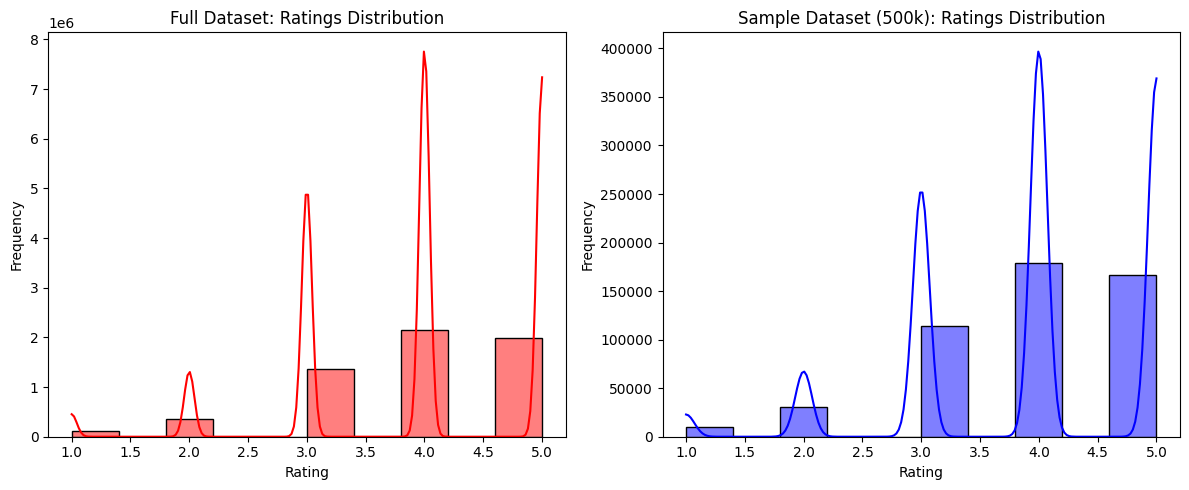

In [11]:

# Take a random sample of 500,000 ratings
ratings_sample = ratings_df.sample(n=500000, random_state=42)

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for full dataset
plt.subplot(1, 2, 1)
sns.histplot(ratings_df['rating'], bins=10, kde=True, color='red')
plt.title("Full Dataset: Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")

# Histogram for sample dataset
plt.subplot(1, 2, 2)
sns.histplot(ratings_sample['rating'], bins=10, kde=True, color='blue')
plt.title("Sample Dataset (500k): Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## Compare Statistical Metrics of Full vs. Sample Dataset

In [12]:
# Calculate statistics for full dataset
full_mean = ratings_df['rating'].mean()
full_median = ratings_df['rating'].median()
full_variance = ratings_df['rating'].var()
full_std_dev = ratings_df['rating'].std()

# Calculate statistics for sample dataset
sample_mean = ratings_sample['rating'].mean()
sample_median = ratings_sample['rating'].median()
sample_variance = ratings_sample['rating'].var()
sample_std_dev = ratings_sample['rating'].std()

# Display results
stats_comparison = pd.DataFrame({
    "Metric": ["Mean", "Median", "Variance", "Standard Deviation"],
    "Full Dataset": [full_mean, full_median, full_variance, full_std_dev],
    "Sample Dataset (500k)": [sample_mean, sample_median, sample_variance, sample_std_dev]
})

print(stats_comparison)

               Metric  Full Dataset  Sample Dataset (500k)
0                Mean      3.919866               3.920744
1              Median      4.000000               4.000000
2            Variance      0.982253               0.982108
3  Standard Deviation      0.991087               0.991014


## Boxplot for Full vs. Sample Ratings Distribution

/tmp/ipykernel_22311/3946556004.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y="rating", data=combined_df, palette=["red", "blue"])


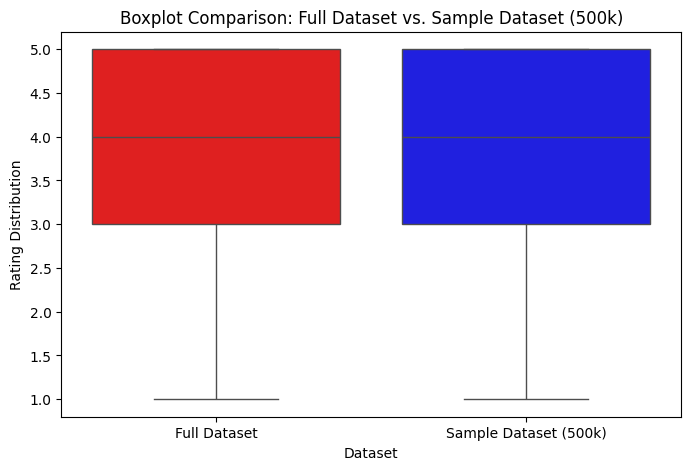

In [13]:

# Create a combined DataFrame for visualization
ratings_df["Dataset"] = "Full Dataset"
ratings_sample["Dataset"] = "Sample Dataset (500k)"

combined_df = pd.concat([ratings_df[['rating', 'Dataset']], ratings_sample[['rating', 'Dataset']]])

# Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="Dataset", y="rating", data=combined_df, palette=["red", "blue"])

plt.title("Boxplot Comparison: Full Dataset vs. Sample Dataset (500k)")
plt.xlabel("Dataset")
plt.ylabel("Rating Distribution")

plt.show()


##  Detect Outliers in Full vs. Sample Dataset

In [14]:
# Function to calculate outliers using IQR
def detect_outliers_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Detect outliers in full dataset
full_outliers, full_lower, full_upper = detect_outliers_iqr(ratings_df, "rating")

# Detect outliers in sample dataset
sample_outliers, sample_lower, sample_upper = detect_outliers_iqr(ratings_sample, "rating")

# Display results
outlier_comparison = pd.DataFrame({
    "Dataset": ["Full Dataset", "Sample Dataset (500k)"],
    "Outlier Count": [full_outliers, sample_outliers],
    "Lower Bound": [full_lower, sample_lower],
    "Upper Bound": [full_upper, sample_upper]
})

print(outlier_comparison)

                 Dataset  Outlier Count  Lower Bound  Upper Bound
0           Full Dataset              0          0.0          8.0
1  Sample Dataset (500k)              0          0.0          8.0


## How book ratings form a probability distribution

### Compute Probability Distribution of Ratings
Each rating (1 to 5) appears with a certain probability. We’ll calculate the probability of each rating from the dataset.

/tmp/ipykernel_22311/1727876485.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="coolwarm")
/home/dennis/ml/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


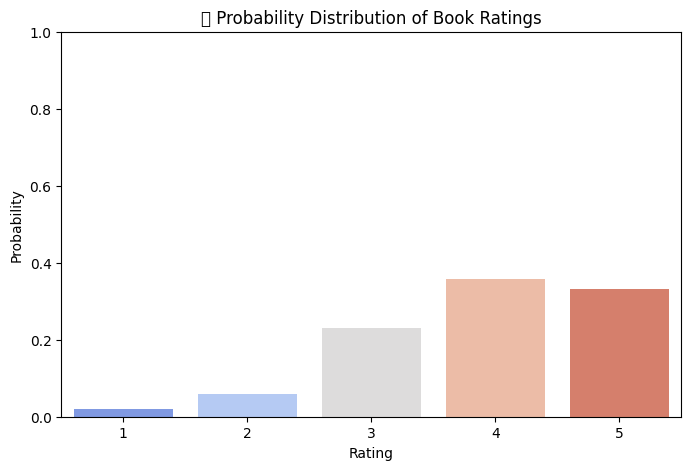

In [15]:
rating_counts = ratings_df["rating"].value_counts(normalize=True).sort_index()

# Plot probability distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="coolwarm")

plt.title("📊 Probability Distribution of Book Ratings")
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.show()


### Compute Expected Value (Mean Rating)

In [16]:
expected_rating = sum(rating_counts.index * rating_counts.values)
print(f"📌 Expected Rating (Mean): {expected_rating:.2f}")

📌 Expected Rating (Mean): 3.92


### Compute Variance & Standard Deviation
Variance tells us how spread out ratings are, while the standard deviation gives the average deviation from the mean.

In [17]:
# Compute variance
variance = sum((rating_counts.index - expected_rating) ** 2 * rating_counts.values)

# Compute standard deviation
std_dev = variance ** 0.5

print(f"📌 Variance of Ratings: {variance:.2f}")
print(f"📌 Standard Deviation of Ratings: {std_dev:.2f}")

📌 Variance of Ratings: 0.98
📌 Standard Deviation of Ratings: 0.99


### Step 4: Compute & Plot the CDF
The CDF represents the probability that a rating is less than or equal to a given value.

/home/dennis/ml/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


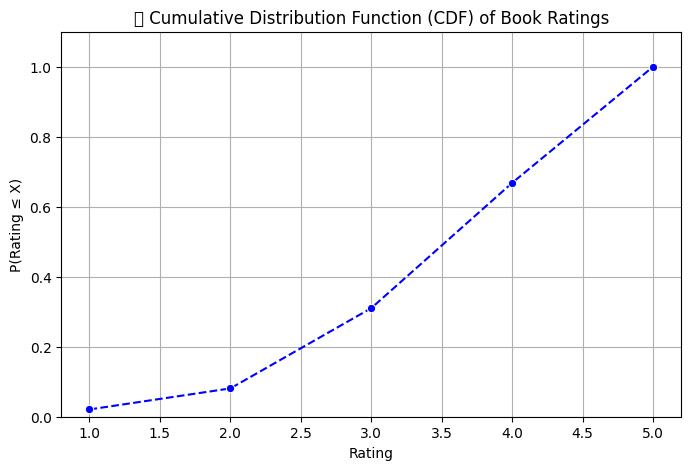

In [18]:

# Compute CDF
cdf_values = np.cumsum(rating_counts.values)

# Plot CDF
plt.figure(figsize=(8, 5))
sns.lineplot(x=rating_counts.index, y=cdf_values, marker="o", linestyle="--", color="b")

plt.title("📈 Cumulative Distribution Function (CDF) of Book Ratings")
plt.xlabel("Rating")
plt.ylabel("P(Rating ≤ X)")
plt.ylim(0, 1.1)
plt.grid()

# Show plot
plt.show()

###  Overlaying the Probability Density Function (PDF) with the Cumulative Distribution Function (CDF) to better understand the distribution of ratings

/home/dennis/ml/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


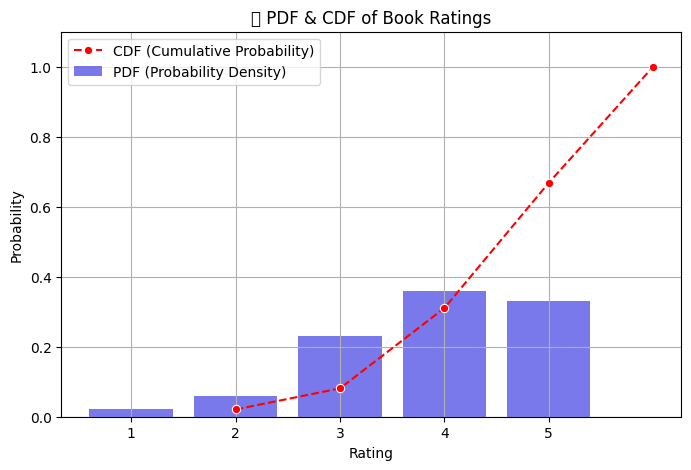

In [20]:
ratings = ratings_df["rating"]

# Get unique ratings and their counts
rating_counts = np.bincount(ratings, minlength=6)[1:]  # Ignore 0 index (ratings start from 1)
rating_values = np.arange(1, 6)  # Possible ratings: {1, 2, 3, 4, 5}

# Normalize to get PDF (probabilities sum to 1)
pdf_values = rating_counts / np.sum(rating_counts)

# Compute CDF (cumulative sum of PDF)
cdf_values = np.cumsum(pdf_values)

# Plot PDF (bar plot)
plt.figure(figsize=(8, 5))
sns.barplot(x=rating_values, y=pdf_values, color="b", alpha=0.6, label="PDF (Probability Density)")

# Plot CDF (line plot)
sns.lineplot(x=rating_values, y=cdf_values, marker="o", linestyle="--", color="r", label="CDF (Cumulative Probability)")

# Labels & Legends
plt.title("📊 PDF & CDF of Book Ratings")
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.ylim(0, 1.1)
plt.legend()
plt.grid()

# Show plot
plt.show()


## Rating Distribution of Three books

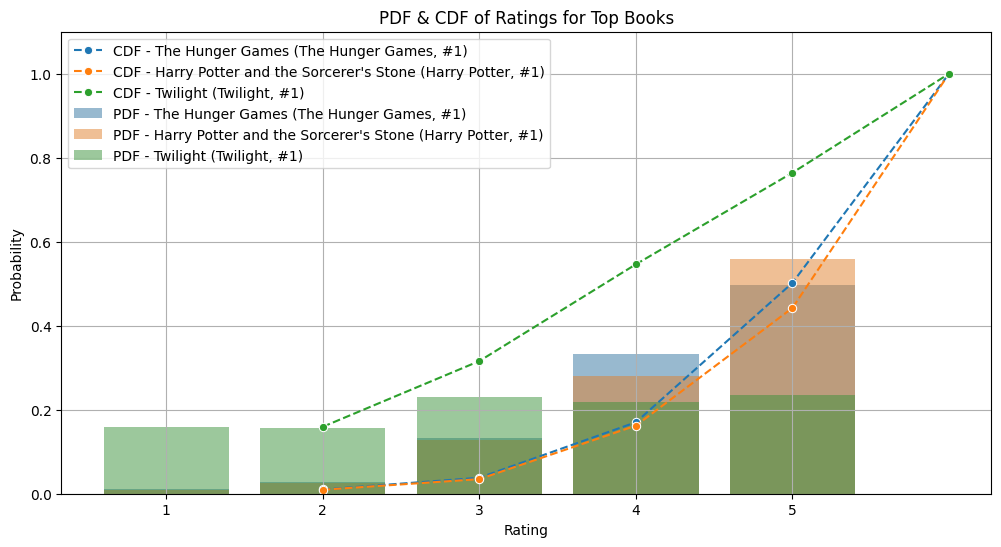

In [21]:

# Select 3 books based on the highest number of ratings
top_books = books_df.nlargest(3, 'ratings_count')

# Extract ratings for the selected books
book_ratings = {}
for _, row in top_books.iterrows():
    book_id = row["book_id"]
    title = row["title"]
    ratings = ratings_df[ratings_df["book_id"] == book_id]["rating"].tolist()
    book_ratings[title] = ratings

# Plot PDF & CDF
plt.figure(figsize=(12, 6))

for book, ratings in book_ratings.items():
    rating_values = np.arange(1, 6)  # Possible ratings {1, 2, 3, 4, 5}
    rating_counts = np.bincount(ratings, minlength=6)[1:]  # Ignore index 0
    pdf_values = rating_counts / np.sum(rating_counts)  # Normalize to get PDF
    cdf_values = np.cumsum(pdf_values)  # Compute CDF

    # Plot PDF
    sns.barplot(x=rating_values, y=pdf_values, alpha=0.5, label=f"PDF - {book}")

    # Plot CDF
    sns.lineplot(x=rating_values, y=cdf_values, marker="o", linestyle="--", label=f"CDF - {book}")

# Labels & Legends
plt.title("PDF & CDF of Ratings for Top Books")
plt.xlabel("Rating")
plt.ylabel("Probability")
plt.ylim(0, 1.1)
plt.legend()
plt.grid()

# Show plot
plt.show()


## Probability of Books with Ratings Near the Mean

Probability that a randomly selected book has a rating count within 100 ratings of the average.

In [22]:

# Compute the actual average rating count
mean_ratings = books_df["ratings_count"].mean()

# Compute probability
probability = ((books_df["ratings_count"] >= (mean_ratings - 100)) & 
               (books_df["ratings_count"] <= (mean_ratings + 100))).mean()

print(f"Mean Ratings Count: {mean_ratings:.2f}")
print(f"Probability of a book having a rating count within ±100 of the mean: {probability:.3f}")


Mean Ratings Count: 54001.24
Probability of a book having a rating count within ±100 of the mean: 0.000


## Check the Distribution

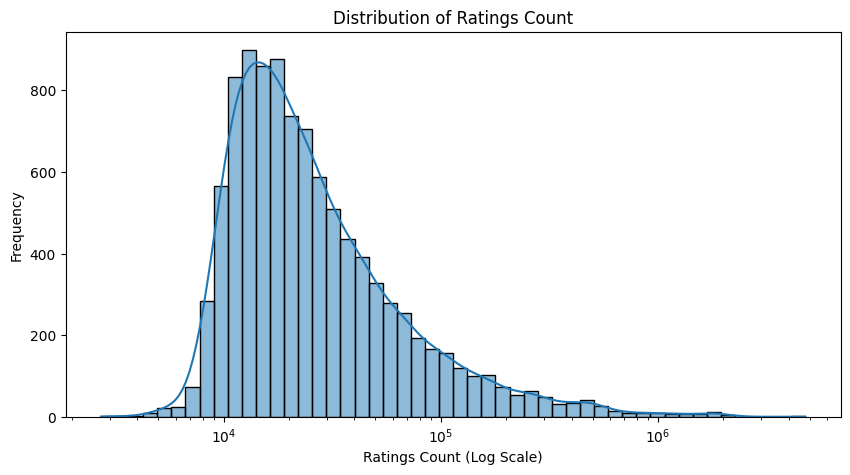

In [23]:

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(books_df["ratings_count"], bins=50, log_scale=True, kde=True)
plt.xlabel("Ratings Count (Log Scale)")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings Count")
plt.show()


## ±10% of the Mean

In [24]:
range_min = mean_ratings * 0.9
range_max = mean_ratings * 1.1

probability = ((books_df["ratings_count"] >= range_min) & 
               (books_df["ratings_count"] <= range_max)).mean()

print(f"Probability of a book having a rating count within ±10% of the mean: {probability:.3f}")

Probability of a book having a rating count within ±10% of the mean: 0.040


## Compute Expectation (Mean Rating)

In [25]:

# Compute the mean rating for each book
mean_ratings = ratings_df.groupby("book_id")["rating"].mean()

# Compute the overall expectation (mean rating across all books)
expected_rating = ratings_df["rating"].mean()

print(f"Expectation (Mean Rating): {expected_rating:.2f}")


Expectation (Mean Rating): 3.92


## Compute Variance and Standard Deviation of Ratings

In [27]:
# Compute variance of ratings per book
variance_ratings = ratings_df.groupby("book_id")["rating"].var()

# Compute the overall variance and standard deviation
overall_variance = ratings_df["rating"].var()
overall_std_dev = ratings_df["rating"].std()

print(f"Variance of Ratings: {overall_variance:.2f}")
print(f"Standard Deviation of Ratings: {overall_std_dev:.2f}")


Variance of Ratings: 0.98
Standard Deviation of Ratings: 0.99


## Compute Expectation and Variance Using Probability Distribution

In [28]:

# Compute the frequency of each rating
rating_counts = ratings_df["rating"].value_counts(normalize=True).sort_index()

# Compute expectation using probability distribution formula
expected_rating_dist = np.sum(rating_counts.index * rating_counts.values)

# Compute variance using probability distribution formula
variance_rating_dist = np.sum((rating_counts.index - expected_rating_dist) ** 2 * rating_counts.values)

# Compute standard deviation
std_dev_rating_dist = np.sqrt(variance_rating_dist)

print(f"Expectation (Mean Rating) from Probability Distribution: {expected_rating_dist:.2f}")
print(f"Variance from Probability Distribution: {variance_rating_dist:.2f}")
print(f"Standard Deviation from Probability Distribution: {std_dev_rating_dist:.2f}")


Expectation (Mean Rating) from Probability Distribution: 3.92
Variance from Probability Distribution: 0.98
Standard Deviation from Probability Distribution: 0.99


## Visualizing Normal Distribution in User Ratings

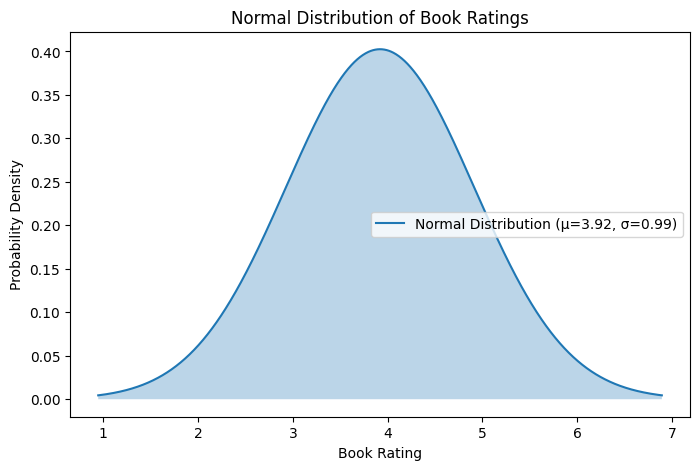

Mean (μ): 3.92
Standard Deviation (σ): 0.99


In [29]:
from scipy.stats import norm

# Compute mean (μ) and standard deviation (σ) from actual ratings
mu = ratings_df["rating"].mean()
sigma = ratings_df["rating"].std()

# Generate values for x-axis (rating range)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)

# Compute normal probability density function (PDF)
pdf_values = norm.pdf(x, mu, sigma)

# Plot the normal distribution
plt.figure(figsize=(8, 5))
plt.plot(x, pdf_values, label=f'Normal Distribution (μ={mu:.2f}, σ={sigma:.2f})')
plt.fill_between(x, pdf_values, alpha=0.3)  # Shade the area under the curve
plt.xlabel('Book Rating')
plt.ylabel('Probability Density')
plt.title('Normal Distribution of Book Ratings')
plt.legend()
plt.show()

# Print actual values
print(f"Mean (μ): {mu:.2f}")
print(f"Standard Deviation (σ): {sigma:.2f}")


## Computing Probabilities
We can calculate the probability of a book's rating falling within a certain range. For example, what’s the probability that a randomly selected book has a rating between **3.5 and 4.5 stars**?


In [30]:

# Compute mean (μ) and standard deviation (σ) from actual ratings
mu = ratings_df["rating"].mean()
sigma = ratings_df["rating"].std()

# Compute the probability using CDF
p_3_5_to_4_5 = norm.cdf(4.5, mu, sigma) - norm.cdf(3.5, mu, sigma)

# Output the result
print(f"Probability that a book rating falls between 3.5 and 4.5: {p_3_5_to_4_5:.4f}")


Probability that a book rating falls between 3.5 and 4.5: 0.3849


## Understanding Variance in Book Ratings

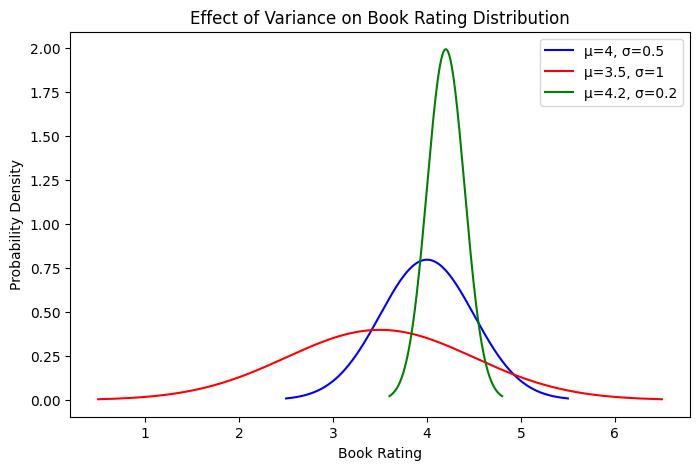

In [31]:

# Calculate the mean (μ) and standard deviation (σ) from actual ratings
mu = ratings_df["rating"].mean()
sigma = ratings_df["rating"].std()

# Different variance values (σ^2)
params = [(4, 0.5), (3.5, 1), (4.2, 0.2)]
colors = ['blue', 'red', 'green']

# Create a plot for the normal distributions
plt.figure(figsize=(8, 5))

# Plot multiple normal distributions with different variances
for (mu, sigma_val), color in zip(params, colors):
    x = np.linspace(mu - 3 * sigma_val, mu + 3 * sigma_val, 1000)
    plt.plot(x, norm.pdf(x, mu, sigma_val), label=f'μ={mu}, σ={sigma_val}', color=color)

# Labeling the plot
plt.xlabel('Book Rating')
plt.ylabel('Probability Density')
plt.title('Effect of Variance on Book Rating Distribution')
plt.legend()
plt.show()


## Understanding Z-Scores in Book Ratings
To standardize a rating, we compute the **z-score**:


In [32]:

# Calculate the mean (μ) and standard deviation (σ) from actual ratings
mu = ratings_df["rating"].mean()
sigma = ratings_df["rating"].std()

# Function to compute z-score
def compute_z_score(x, mu, sigma):
    return (x - mu) / sigma

# Compute z-scores for ratings
z_3 = compute_z_score(3, mu, sigma)
z_5 = compute_z_score(5, mu, sigma)

# Print z-scores for 3-star and 5-star ratings
print(f"Z-score for a 3-star book: {z_3:.2f}")
print(f"Z-score for a 5-star book: {z_5:.2f}")


Z-score for a 3-star book: -0.93
Z-score for a 5-star book: 1.09


## Computing Probabilities Using the Standard Normal Distribution

Compute the probability that a randomly selected book has a rating between **3.5 and 4.5 stars**, using **z-scores**.

In [33]:

# Calculate the mean (μ) and standard deviation (σ) from the actual ratings
mu = ratings_df["rating"].mean()
sigma = ratings_df["rating"].std()

# Compute z-scores for ratings 3.5 and 4.5
z_3_5 = (3.5 - mu) / sigma
z_4_5 = (4.5 - mu) / sigma

# Compute probability using standard normal CDF
p_3_5_to_4_5 = norm.cdf(z_4_5) - norm.cdf(z_3_5)
print(f"Probability that a book rating falls between 3.5 and 4.5: {p_3_5_to_4_5:.4f}")


Probability that a book rating falls between 3.5 and 4.5: 0.3849


## Detecting Outliers in Book Ratings**
Books with very high or low **z-scores** (e.g., \(|z| > 2\)) can be flagged as:
- **Exceptionally popular**
- **Highly controversial**

In [3]:
import scipy.stats as stats

# Calculate the mean (μ) and standard deviation (σ) from the ratings
mu = ratings_df["rating"].mean()
sigma = ratings_df["rating"].std()

# Function to compute z-score
def compute_z_score(x, mu, sigma):
    return (x - mu) / sigma

# Function to detect outliers
def detect_outliers(ratings, mu, sigma, threshold=2):
    # Calculate z-scores for each rating
    z_scores = [(rating, compute_z_score(rating, mu, sigma)) for rating in ratings]
    
    # Flag outliers (|z| > threshold)
    outliers = [(rating, z) for rating, z in z_scores if abs(z) > threshold]
    
    return outliers

# Get the list of all ratings
ratings_list = ratings_df["rating"].tolist()

# Detect outliers
outliers = detect_outliers(ratings_list, mu, sigma)

# Print outliers
print(f"Found {len(outliers)} outliers in book ratings.")
#for rating, z in outliers:
    #print(f"Rating: {rating}, Z-score: {z:.2f}")


Found 124195 outliers in book ratings.


## Compute percentiles and detect outliers 

95% of book ratings fall between 1.98 and 5.86
Q1 (25th percentile): 3.00
Q3 (75th percentile): 5.00
IQR: 2.00
Outlier threshold: Below 0.00 or Above 8.00
Total Outliers Found: 0


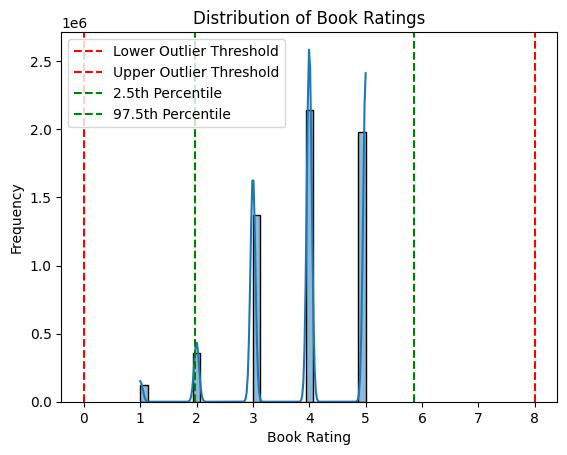

In [40]:
import scipy.stats as stats

# Step 1: Calculate the mean and standard deviation of ratings from the user_ratings dataset
mu = ratings_df['rating'].mean()
sigma = ratings_df['rating'].std()

# Compute the 2.5th and 97.5th percentile values to represent the 95% central range
lower_bound = stats.norm.ppf(0.025, loc=mu, scale=sigma)
upper_bound = stats.norm.ppf(0.975, loc=mu, scale=sigma)

print(f"95% of book ratings fall between {lower_bound:.2f} and {upper_bound:.2f}")

# Step 2: Compute Q1 (25th percentile) and Q3 (75th percentile) for ratings
Q1 = np.percentile(ratings_df['rating'], 25)
Q3 = np.percentile(ratings_df['rating'], 75)

# Compute the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define outlier thresholds using 1.5 * IQR
lower_outlier_threshold = Q1 - 1.5 * IQR
upper_outlier_threshold = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Outlier threshold: Below {lower_outlier_threshold:.2f} or Above {upper_outlier_threshold:.2f}")

# Step 3: Detect outliers based on the IQR method
outliers = ratings_df[(ratings_df['rating'] < lower_outlier_threshold) | 
                           (ratings_df['rating'] > upper_outlier_threshold)]

print(f"Total Outliers Found: {len(outliers)}")

# Step 4: Plotting the distribution of ratings with the outlier thresholds
sns.histplot(ratings_df['rating'], bins=30, kde=True)
plt.axvline(lower_outlier_threshold, color='red', linestyle='dashed', label='Lower Outlier Threshold')
plt.axvline(upper_outlier_threshold, color='red', linestyle='dashed', label='Upper Outlier Threshold')
plt.axvline(lower_bound, color='green', linestyle='dashed', label='2.5th Percentile')
plt.axvline(upper_bound, color='green', linestyle='dashed', label='97.5th Percentile')
plt.legend()
plt.xlabel('Book Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Book Ratings')
plt.show()

## Sampling Distribution 

                                                  title  average_rating
6252                 Scion of Ikshvaku (RamChandra, #1)            3.69
4684                                             Canada            3.49
1731                          The Man in the Brown Suit            3.97
4742  Twilight and Philosophy: Vampires, Vegetarians...            4.39
4521                            Saga, Vol. 5 (Saga, #5)            4.44


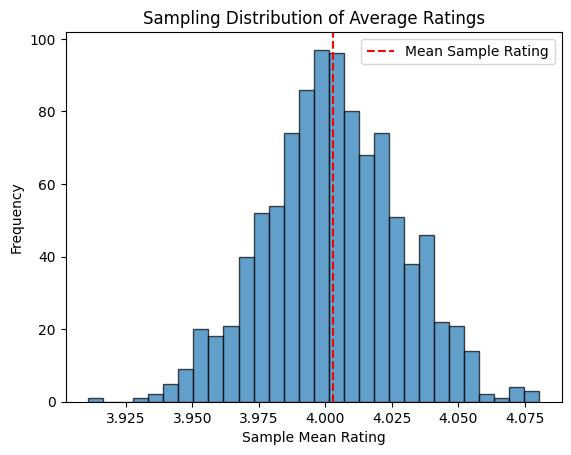

Population Mean Rating: 4.002
Sample Mean Rating: 4.002
Probability that sample mean is within 0.1 of population mean: 1.000


In [41]:

# Step 2: Take a random sample of 100 books from the dataset
sampled_books = books_df.sample(n=100, random_state=42)

# Display the sampled books with 'title' and 'average_rating'
print(sampled_books[['title', 'average_rating']].head())

# Step 3: Compute the Sampling Distribution of Mean Ratings
# Function to generate multiple samples and compute their means
def compute_sample_means(books_df, num_samples=1000, sample_size=100):
    sample_means = []
    for _ in range(num_samples):
        sampled_ratings = books_df['average_rating'].sample(n=sample_size)
        sample_means.append(sampled_ratings.mean())
    return sample_means

# Compute the sampling distribution
sample_means = compute_sample_means(books_df)

# Plot the histogram of sample means
plt.hist(sample_means, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(sample_means), color='red', linestyle='dashed', label="Mean Sample Rating")
plt.xlabel("Sample Mean Rating")
plt.ylabel("Frequency")
plt.title("Sampling Distribution of Average Ratings")
plt.legend()
plt.show()

# Step 4: Compare Sample Mean to Population Mean
# Compute the population mean
population_mean = books_df['average_rating'].mean()

# Compute the mean of a single random sample
sample_mean = sampled_books['average_rating'].mean()

# Print comparison
print(f"Population Mean Rating: {population_mean:.3f}")
print(f"Sample Mean Rating: {sample_mean:.3f}")

# Step 5: Probability of Sample Mean Being Close to Population Mean
# Compute probability of sample mean being within 0.1 of population mean
probability_within_01 = np.mean(np.abs(np.array(sample_means) - population_mean) <= 0.1)

print(f"Probability that sample mean is within 0.1 of population mean: {probability_within_01:.3f}")


## **Theoretical Models in Book Recommendation Systems**
Sampling distributions help us evaluate the reliability of rating-based predictions in book recommendation systems. Suppose user ratings for a book follow a **Binomial distribution**, where a user assigns a rating from 1 to 5, with a probability of 0.5 for a high rating (4 or 5). 

Now, if we collect ratings from **64 independent users**, we can analyze the **sampling distribution of the average rating** using Python.

In [ ]:

# Check for missing values in ratings
print(ratings_df.isnull().sum())

# Filter the dataset to get ratings for books with at least some ratings
book_ratings = ratings_df.groupby('book_id')['rating'].count()
books_with_ratings = book_ratings[book_ratings >= 64]  # Filter books with at least 64 ratings

# Extract ratings data for those books
filtered_ratings = ratings_df[ratings_df['book_id'].isin(books_with_ratings.index)]

# Number of simulations
num_simulations = 100000
sample_size = 64

# Simulate the sampling distribution of average ratings
sample_means = np.zeros(num_simulations)

for i in range(num_simulations):
    # Randomly select 64 ratings for a book
    ratings_sample = filtered_ratings.sample(n=sample_size, random_state=i)['rating']
    sample_means[i] = ratings_sample.mean()

# Plot the histogram of sample means
plt.hist(sample_means, bins=30, edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Average Predicted Rating')
plt.ylabel('Frequency')
plt.title('Sampling Distribution of Book Ratings')

# Overlay Normal Distribution Curve
mu, sigma = np.mean(sample_means), np.std(sample_means)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r', label='Normal Approximation')
plt.legend()
plt.show()

# Compute and print mean and standard deviation of sample means
print("Mean of Sample Means:", np.mean(sample_means))
print("Standard Deviation of Sample Means:", np.std(sample_means))

# Theoretical calculations for expected value and variance
expected_value = 5 * 0.5  # Binomial(5, 0.5) => mean = n * p
variance = (5 * 0.5 * 0.5) / sample_size  # Variance of sample mean
std_dev = np.sqrt(variance)

print("Theoretical Expected Value (Mean):", expected_value)
print("Theoretical Standard Deviation:", std_dev)

# Empirical 95% confidence interval from sample means
ci_empirical = np.percentile(sample_means, [2.5, 97.5])
print("Empirical 95% Confidence Interval:", ci_empirical)

# Normal approximation 95% confidence interval
ci_normal = stats.norm.ppf([0.025, 0.975], np.mean(sample_means), np.std(sample_means))
print("Normal Approximation 95% Confidence Interval:", ci_normal)


user_id    0
book_id    0
rating     0
z_score    0
Dataset    0
dtype: int64


## The Law of Large Numbers (LLN

In [ ]:

# Filter books that have at least 64 ratings (using ratings_count column in books_df)
book_ratings_count = books_df[books_df['ratings_count'] >= 64]

# Merge datasets to get the ratings for books with sufficient ratings
filtered_ratings = ratings_df[ratings_df['book_id'].isin(book_ratings_count['book_id'])]

# Define function to simulate LLN (convergence of sample mean)
def simulate_lln(book_ratings, n_samples, num_simulations=100000):
    sample_means = np.zeros(num_simulations)

    for i in range(num_simulations):
        sample = np.random.choice(book_ratings, size=n_samples, replace=True)
        sample_means[i] = np.mean(sample)

    return sample_means

# Simulate LLN for different sample sizes
sample_means_10 = simulate_lln(filtered_ratings['rating'].values, 10)
sample_means_100 = simulate_lln(filtered_ratings['rating'].values, 100)
sample_means_1000 = simulate_lln(filtered_ratings['rating'].values, 1000)

# Plot LLN simulations
plt.figure(figsize=(12, 5))
plt.hist(sample_means_10, bins=30, alpha=0.6, label="n = 10", density=True)
plt.hist(sample_means_100, bins=30, alpha=0.6, label="n = 100", density=True)
plt.hist(sample_means_1000, bins=30, alpha=0.6, label="n = 1000", density=True)
plt.axvline(filtered_ratings['rating'].mean(), color='k', linestyle='dashed', linewidth=2, label="True Mean")
plt.xlabel("Sample Mean")
plt.ylabel("Density")
plt.title("Law of Large Numbers - Convergence of Sample Mean")
plt.legend()
plt.show()

# Print the mean estimates for different sample sizes
print("Mean for n=10:", np.mean(sample_means_10))
print("Mean for n=100:", np.mean(sample_means_100))
print("Mean for n=1000:", np.mean(sample_means_1000))

# Define function to simulate CLT (distribution of sample means)
def simulate_clt(book_ratings, n_samples, num_simulations=100000):
    sample_means = np.zeros(num_simulations)

    for i in range(num_simulations):
        sample = np.random.choice(book_ratings, size=n_samples, replace=True)
        sample_means[i] = np.mean(sample)

    return sample_means

# Simulate CLT for different sample sizes
clt_means_10 = simulate_clt(filtered_ratings['rating'].values, 10)
clt_means_100 = simulate_clt(filtered_ratings['rating'].values, 100)
clt_means_1000 = simulate_clt(filtered_ratings['rating'].values, 1000)

# Plot CLT simulations
plt.figure(figsize=(12, 5))
plt.hist(clt_means_10, bins=30, alpha=0.6, label="n = 10", density=True)
plt.hist(clt_means_100, bins=30, alpha=0.6, label="n = 100", density=True)
plt.hist(clt_means_1000, bins=30, alpha=0.6, label="n = 1000", density=True)
plt.axvline(filtered_ratings['rating'].mean(), color='k', linestyle='dashed', linewidth=2, label="True Mean")
plt.xlabel("Sample Mean")
plt.ylabel("Density")
plt.title("Central Limit Theorem - Distribution of Sample Means")
plt.legend()
plt.show()

# Print the mean estimates for CLT simulations
print("Mean for n=10:", np.mean(clt_means_10))
print("Mean for n=100:", np.mean(clt_means_100))
print("Mean for n=1000:", np.mean(clt_means_1000))



## Applying the Central Limit Theorem

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Step 1: Load the Datasets
# Load the books and ratings datasets
books_df = pd.read_csv("books.csv")
ratings_df = pd.read_csv("ratings.csv")

# Inspect the first few rows of the datasets
print(books_df.head())
print(ratings_df.head())

# Step 2: Visualize the Rating Distribution
# Plot histogram of book ratings
plt.figure(figsize=(8, 5))
sns.histplot(ratings_df['rating'], bins=20, kde=True)
plt.xlabel("Book Rating")
plt.ylabel("Count")
plt.title("Distribution of Book Ratings")
plt.show()

# Step 3: Function to Simulate CLT and Calculate Sample Means
# Function to simulate sampling and calculate sample means
def sample_means(data, sample_size, num_samples=1000):
    means = [np.mean(np.random.choice(data, size=sample_size, replace=True)) for _ in range(num_samples)]
    return means

# Sample sizes to test
sample_sizes = [10, 50, 100, 500]

# Store sample mean distributions
sampled_means = {}

for size in sample_sizes:
    sampled_means[size] = sample_means(ratings_df['rating'], sample_size=size)

# Step 4: Plot Distributions of Sample Means
# Plot distributions of sample means
plt.figure(figsize=(12, 8))
for size in sample_sizes:
    sns.histplot(sampled_means[size], bins=30, kde=True, label=f"n={size}", alpha=0.6)

plt.xlabel("Sample Mean of Ratings")
plt.ylabel("Frequency")
plt.title("Central Limit Theorem: Distribution of Sample Means")
plt.legend()
plt.show()

# Step 5: Estimating Confidence Intervals for Ratings
# Function to compute confidence interval
def confidence_interval(data, sample_size, confidence=0.95):
    sample = np.random.choice(data, size=sample_size, replace=True)
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)  # Sample standard deviation
    margin_error = stats.t.ppf((1 + confidence) / 2, df=sample_size - 1) * (sample_std / np.sqrt(sample_size))
    
    return sample_mean - margin_error, sample_mean + margin_error

# Example: Confidence interval for a sample of ratings
lower, upper = confidence_interval(ratings_df['rating'], sample_size=100)
print(f"95% Confidence Interval for Rating Mean: ({lower:.2f}, {upper:.2f})")


## Statistical Inference

Books Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              

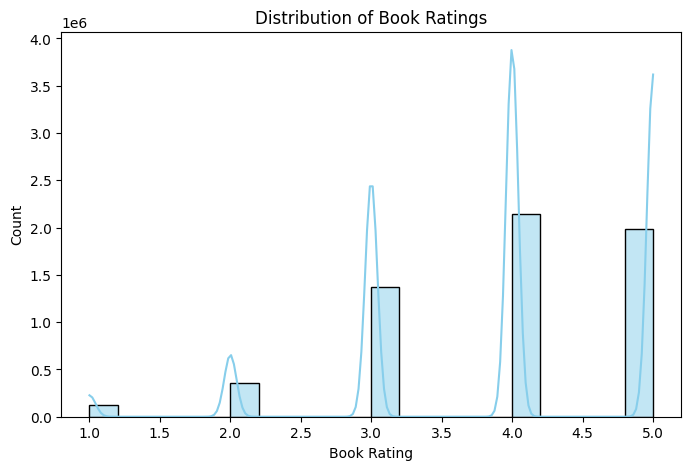

/tmp/ipykernel_4679/3456695371.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_books['ratings_count'], y=top_books['title'], palette="Blues_r")


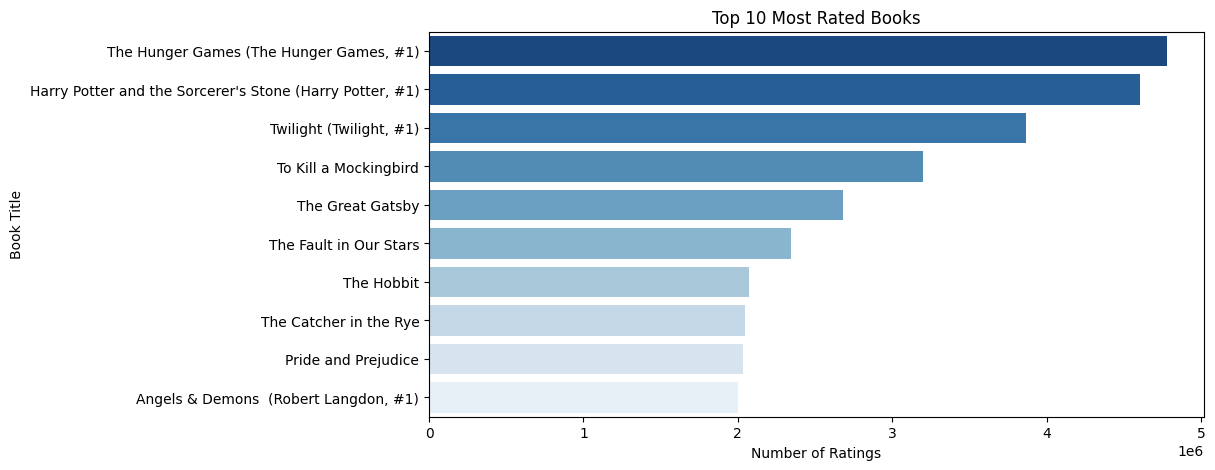


Estimated Average Rating: 3.84

95% Confidence Interval: (3.62, 4.06)


NameError: name 'ratings' is not defined

In [6]:
# Display dataset information
print("Books Dataset Info:")
print(books_df.info())
print("\nRatings Dataset Info:")
print(ratings_df.info())

# Check for missing values
print("\nMissing Values in Books Dataset:")
print(books_df.isnull().sum())

print("\nMissing Values in Ratings Dataset:")
print(ratings_df.isnull().sum())

# Summary statistics
print("\nBooks Dataset Summary:")
print(books_df.describe())

print("\nRatings Dataset Summary:")
print(ratings_df.describe())

# --- EXPLORATORY DATA ANALYSIS (EDA) ---

# Distribution of book ratings
plt.figure(figsize=(8, 5))
sns.histplot(ratings_df['rating'], bins=20, kde=True, color='skyblue')
plt.xlabel("Book Rating")
plt.ylabel("Count")
plt.title("Distribution of Book Ratings")
plt.show()

# Top 10 most-rated books
top_books = books_df.nlargest(10, 'ratings_count')
plt.figure(figsize=(10, 5))
sns.barplot(x=top_books['ratings_count'], y=top_books['title'], palette="Blues_r")
plt.xlabel("Number of Ratings")
plt.ylabel("Book Title")
plt.title("Top 10 Most Rated Books")
plt.show()

# --- POINT ESTIMATION: SAMPLE MEAN ---
sample_ratings = ratings_df["rating"].sample(100, random_state=42)
estimated_mean = sample_ratings.mean()
print(f"\nEstimated Average Rating: {estimated_mean:.2f}")

# --- CONFIDENCE INTERVAL FOR AVERAGE BOOK RATINGS ---
sample_size = len(sample_ratings)
sample_mean = sample_ratings.mean()
sample_std = sample_ratings.std()

z_score = stats.norm.ppf(0.975)  # 95% confidence level
margin_of_error = z_score * (sample_std / np.sqrt(sample_size))

lower_bound = sample_mean - margin_of_error
upper_bound = sample_mean + margin_of_error

print(f"\n95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

# --- CENTRAL LIMIT THEOREM: SAMPLE MEAN DISTRIBUTION ---
def sample_means(data, sample_size, num_samples=1000):
    means = [np.mean(np.random.choice(data, size=sample_size, replace=True)) for _ in range(num_samples)]
    return means

sample_sizes = [10, 50, 100, 500]
sampled_means = {size: sample_means(ratings['rating'], sample_size=size) for size in sample_sizes}

plt.figure(figsize=(12, 8))
for size in sample_sizes:
    sns.histplot(sampled_means[size], bins=30, kde=True, label=f"n={size}", alpha=0.6)

plt.xlabel("Sample Mean of Ratings")
plt.ylabel("Frequency")
plt.title("Central Limit Theorem: Distribution of Sample Means")
plt.legend()
plt.show()

# --- HYPOTHESIS TESTING: DOES A NEW ALGORITHM IMPROVE RATINGS? ---
if "algorithm" in ratings_df.columns:
    old_ratings = ratings_df[ratings_df["algorithm"] == "old"]["rating"]
    new_ratings = ratings_df[ratings_df["algorithm"] == "new"]["rating"]

    t_stat, p_value = stats.ttest_ind(new_ratings, old_ratings, equal_var=False)
    
    print(f"\nT-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("We reject the null hypothesis: The new algorithm significantly improves ratings.")
    else:
        print("We fail to reject the null hypothesis: No significant improvement detected.")
else:
    print("\nAlgorithm column not found in dataset. Skipping hypothesis testing.")

# --- REGRESSION ANALYSIS: FACTORS INFLUENCING BOOK RATINGS ---
if {"ratings_count", "original_publication_year", "average_rating"}.issubset(books_df.columns):
    X = books_df[["ratings_count", "original_publication_year"]]
    y = books_df["average_rating"]

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print("\nRegression Model Summary:")
    print(model.summary())
else:
    print("\nRequired columns for regression analysis not found in books dataset.")

# --- END OF SCRIPT ---
print("\nAnalysis Complete.")


##  Sampling Distribution

Books Dataset: 10000 rows
Ratings Dataset: 5976479 rows

Top 10 Books with Most Ratings:
title
The Hunger Games (The Hunger Games, #1)                        22806
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)       21850
To Kill a Mockingbird                                          19088
Twilight (Twilight, #1)                                        16931
The Great Gatsby                                               16604
Catching Fire (The Hunger Games, #2)                           16549
Mockingjay (The Hunger Games, #3)                              15953
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)    15855
Harry Potter and the Chamber of Secrets (Harry Potter, #2)     15657
The Hobbit                                                     15558
Name: rating, dtype: int64


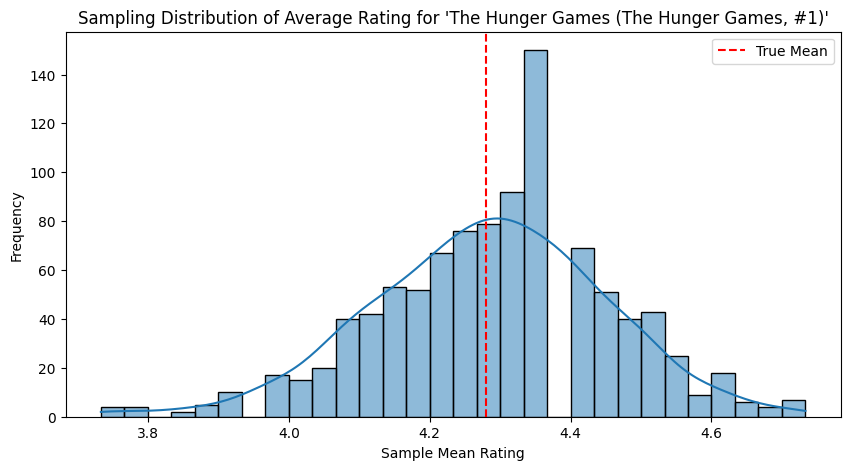


95% Confidence Interval for 'The Hunger Games (The Hunger Games, #1)': (4.27, 4.29)

Hypothesis Test for 'The Hunger Games (The Hunger Games, #1)':
T-statistic: 48.626, P-value: 0.000
Reject H0: 'The Hunger Games (The Hunger Games, #1)' has a significantly higher rating than 4.0


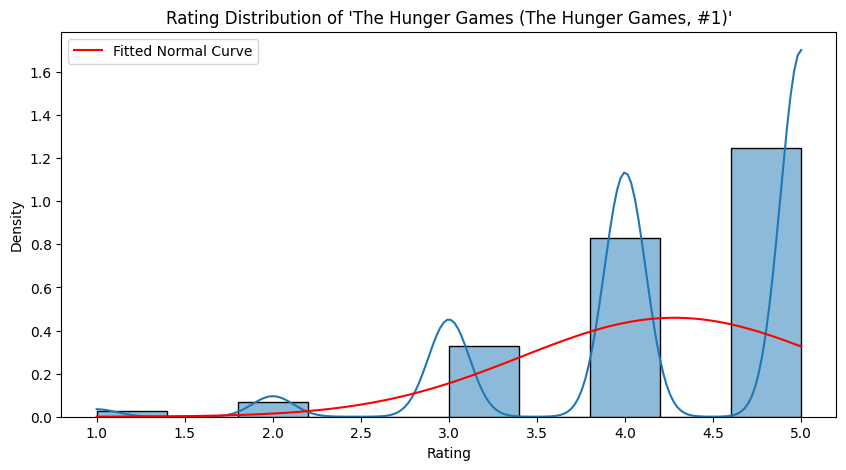

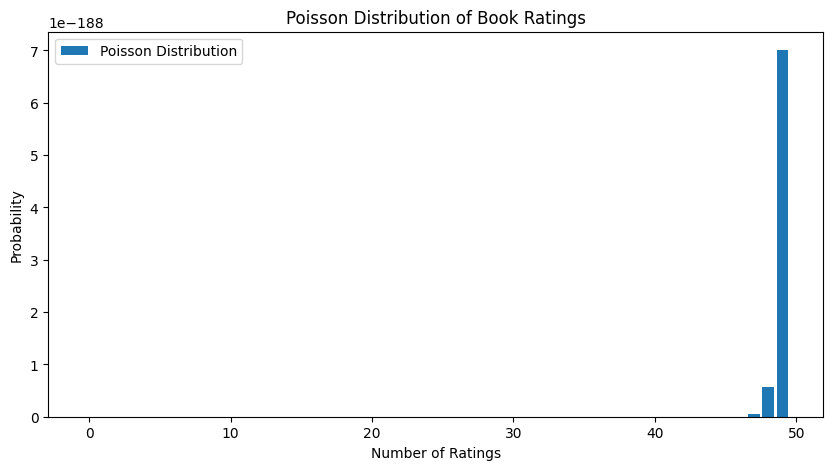

In [8]:

# Merge datasets to get book titles with ratings
df = ratings_df.merge(books_df[['book_id', 'title']], on='book_id')

# Display dataset info
print(f"Books Dataset: {books_df.shape[0]} rows")
print(f"Ratings Dataset: {ratings_df.shape[0]} rows")

# Compute basic statistics
book_avg_ratings = df.groupby("title")["rating"].mean()
book_rating_std = df.groupby("title")["rating"].std()
book_rating_count = df.groupby("title")["rating"].count()

# Display top 10 books with most ratings
top_books = book_rating_count.sort_values(ascending=False).head(10)
print("\nTop 10 Books with Most Ratings:")
print(top_books)

# Select a popular book
book_title = top_books.index[0]  # Most rated book

# Extract ratings for the selected book
book_ratings = df[df["title"] == book_title]["rating"].dropna()

# Sampling Distribution of the Mean
sample_size = 30
num_samples = 1000

# Generate multiple samples and compute means
sample_means = [np.mean(np.random.choice(book_ratings, size=sample_size, replace=True)) for _ in range(num_samples)]

# Plot Sampling Distribution
plt.figure(figsize=(10, 5))
sns.histplot(sample_means, kde=True, bins=30)
plt.axvline(np.mean(book_ratings), color='red', linestyle='dashed', label="True Mean")
plt.title(f"Sampling Distribution of Average Rating for '{book_title}'")
plt.xlabel("Sample Mean Rating")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Compute 95% Confidence Interval
sample_mean = np.mean(book_ratings)
sample_sem = sem(book_ratings)
ci_lower, ci_upper = sample_mean - 1.96 * sample_sem, sample_mean + 1.96 * sample_sem

print(f"\n95% Confidence Interval for '{book_title}': ({ci_lower:.2f}, {ci_upper:.2f})")

# Hypothesis Testing: Is the book rating higher than 4.0?
t_stat, p_value = ttest_1samp(book_ratings, 4.0)

print(f"\nHypothesis Test for '{book_title}':")
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

alpha = 0.05
if p_value < alpha:
    print(f"Reject H0: '{book_title}' has a significantly higher rating than 4.0")
else:
    print(f"Fail to reject H0: No significant evidence that '{book_title}' has a rating higher than 4.0")

# Plot Normal Distribution Fit for Book Ratings
mu, sigma = norm.fit(book_ratings)

plt.figure(figsize=(10,5))
sns.histplot(book_ratings, kde=True, bins=10, stat="density")
x = np.linspace(min(book_ratings), max(book_ratings), 100)
plt.plot(x, norm.pdf(x, mu, sigma), color="red", label="Fitted Normal Curve")
plt.title(f"Rating Distribution of '{book_title}'")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()
plt.show()

# Poisson Distribution: Number of Ratings per Book
lambda_ = np.mean(book_rating_count)
x = np.arange(0, max(book_rating_count))
poisson_pmf = poisson.pmf(x, lambda_)

plt.figure(figsize=(10,5))
plt.bar(x[:50], poisson_pmf[:50], label="Poisson Distribution")  # Limiting to 50 books for clarity
plt.xlabel("Number of Ratings")
plt.ylabel("Probability")
plt.title("Poisson Distribution of Book Ratings")
plt.legend()
plt.show()